In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
!pip install ultralytics --quiet

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import os
import yaml
import glob
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from ultralytics import YOLO

from PIL import Image

seed = 1
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

sns.set_theme(style="darkgrid", font="SimHei", rc={"axes.unicode_minus":False})

In [ ]:
model = YOLO("yolov8n.pt")

In [ ]:
config = {
    "path": "/kaggle/input/the-drug-name-detection-dataset",
    "train": "/kaggle/input/the-drug-name-detection-dataset/train",
    "val": "/kaggle/input/the-drug-name-detection-dataset/valid",
    "test": "/kaggle/input/the-drug-name-detection-dataset/test",
    "nc": 1,
    "names": ["drug-name"],
}

with open("data.yaml", "w") as file:
    yaml.dump(config, file, default_flow_style=False)

In [ ]:
!wandb disabled

In [ ]:
results = model.train(data="data.yaml", epochs=100, save_period=10, seed=seed, name="yolov8n")

In [ ]:
metrics = model.val()

In [ ]:
print(metrics.box.map)

In [ ]:
paths = glob.glob("/kaggle/input/the-drug-name-detection-dataset/test/images/*")

In [ ]:
n = 10
results = model.predict(paths[:n])
for i in range(n):
    r = results[i]
    img = Image.fromarray(r.plot())
    plt.figure(dpi=100)
    plt.imshow(img)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

# Other Models

In [ ]:
import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.transforms import functional as F
from PIL import ImageDraw
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset, DataLoader
import yaml
import os
from tqdm import tqdm

In [ ]:
# Load configuration from data.yaml
with open("data.yaml", "r") as file:
    config = yaml.safe_load(file)

In [ ]:
# Define a custom dataset class
class CustomDataset(Dataset):
    def __init__(self, root_dir, subset, transform=None):
        self.root_dir = os.path.join(root_dir, subset, 'images')
        self.transform = transform
        self.image_files = sorted(os.listdir(self.root_dir))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.image_files[idx])
        image = Image.open(img_name).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image

In [ ]:
# Create the test dataset
test_dataset = CustomDataset(root_dir=config["path"], subset="test", transform=ToTensor())

# Define the dataloader
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=4)

In [ ]:
# Load the Fast R-CNN model
model = fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()

# Move the model to the appropriate device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [ ]:
# Perform predictions
predictions = []
with torch.no_grad():
    for images in tqdm(test_dataloader, desc="Predicting"):
        images = [image.to(device) for image in images]

        # Forward pass
        outputs = model(images)

        # Post-process predictions (customize according to your dataset)
        for i in range(len(outputs)):
            # Extract bounding boxes, labels, and scores from the model's output
            boxes = outputs[i]['boxes'].cpu().numpy()
            labels = outputs[i]['labels'].cpu().numpy()
            scores = outputs[i]['scores'].cpu().numpy()

            # Store predictions in a list
            predictions.append({'boxes': boxes, 'labels': labels, 'scores': scores})

In [ ]:
# Visualize results (customize according to your dataset)
def visualize_results(image, prediction, output_path):
    image = F.to_pil_image(image.cpu())
    draw = ImageDraw.Draw(image)
    for box, label, score in zip(prediction['boxes'], prediction['labels'], prediction['scores']):
        if score > 0.5:  # Adjust confidence threshold as needed
            draw.rectangle(box.tolist(), outline='red', width=2)
            draw.text((box[0], box[1]), f'Class: {label}, Score: {score:.2f}', fill='red')
    image.save(output_path)

# Visualize and save predictions for a few test images
output_dir = '/kaggle/working/predictions'
os.makedirs(output_dir, exist_ok=True)

for i, (image, prediction) in enumerate(zip(test_dataset, predictions)):
    output_path = os.path.join(output_dir, f'prediction_{i + 1}.png')
    visualize_results(image, prediction, output_path)

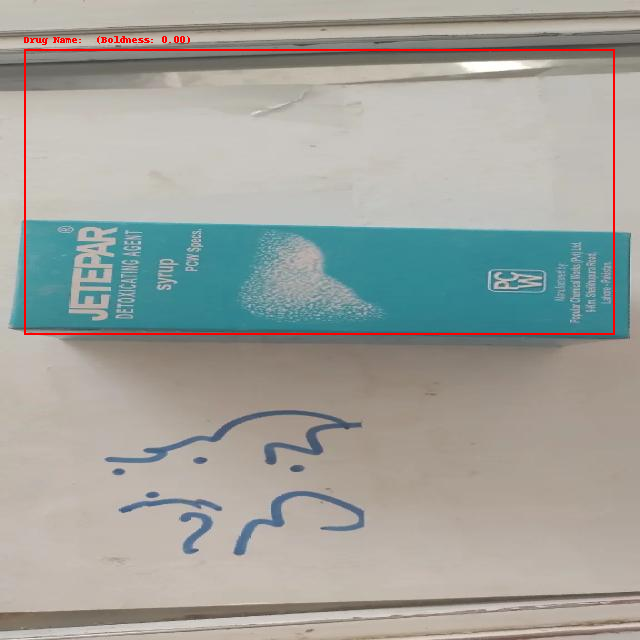

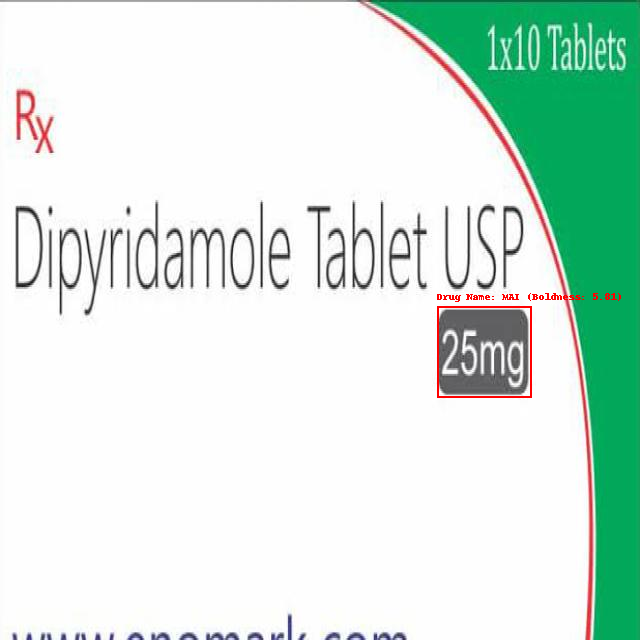

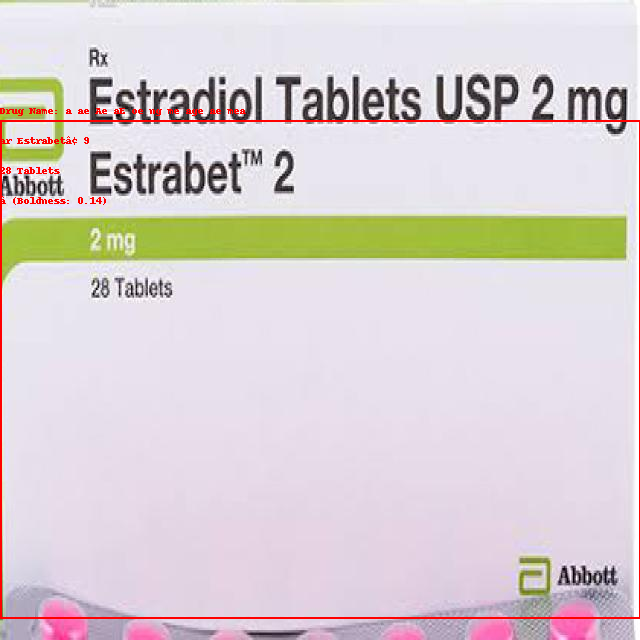

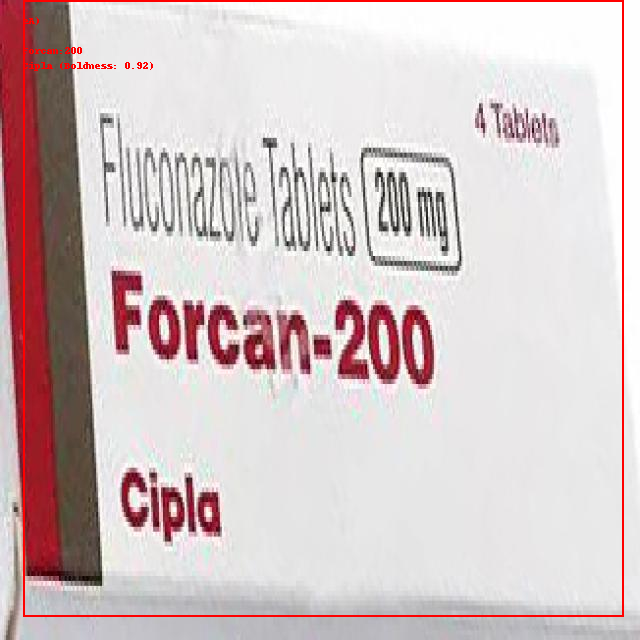

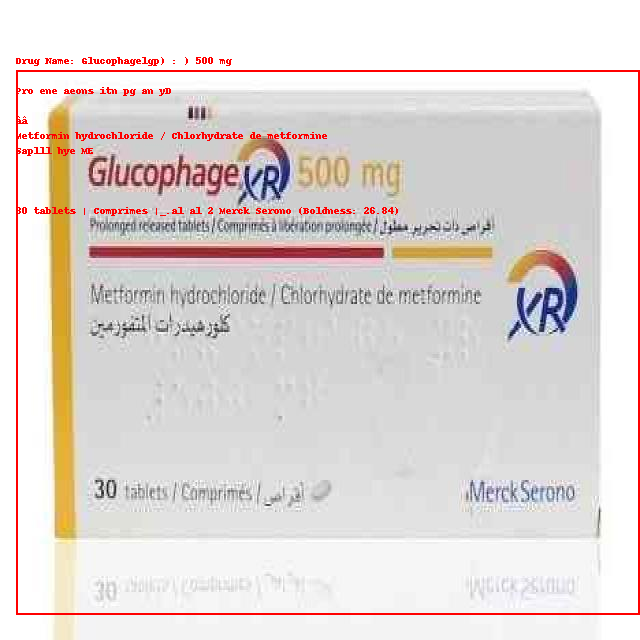

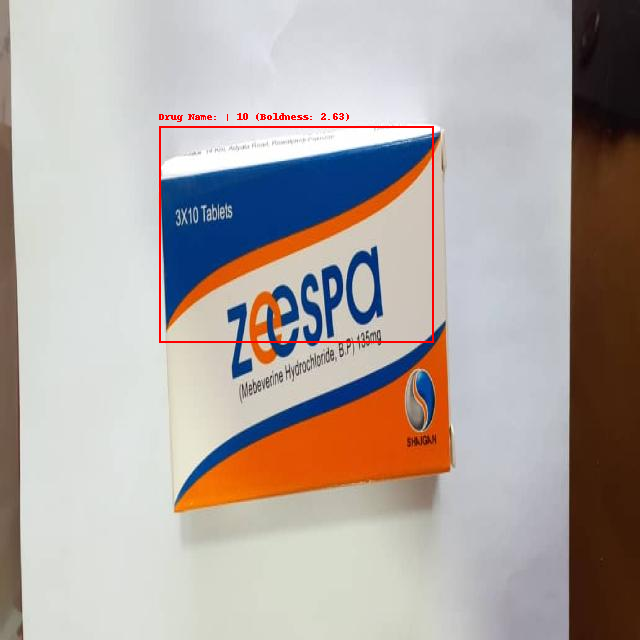

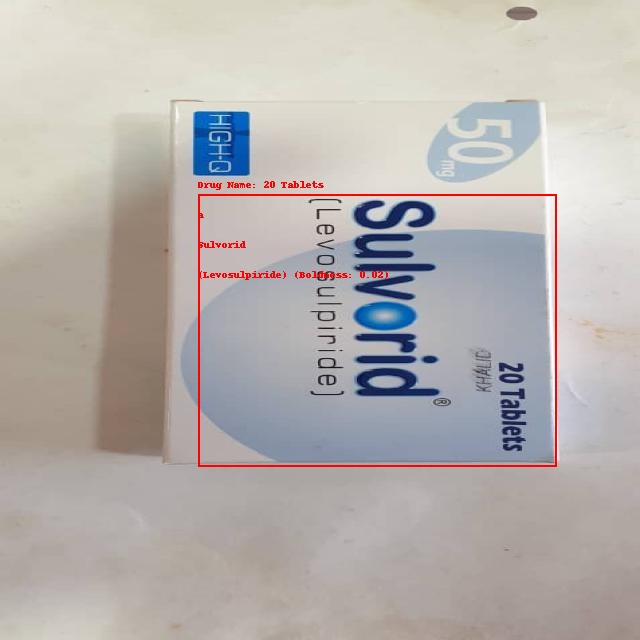

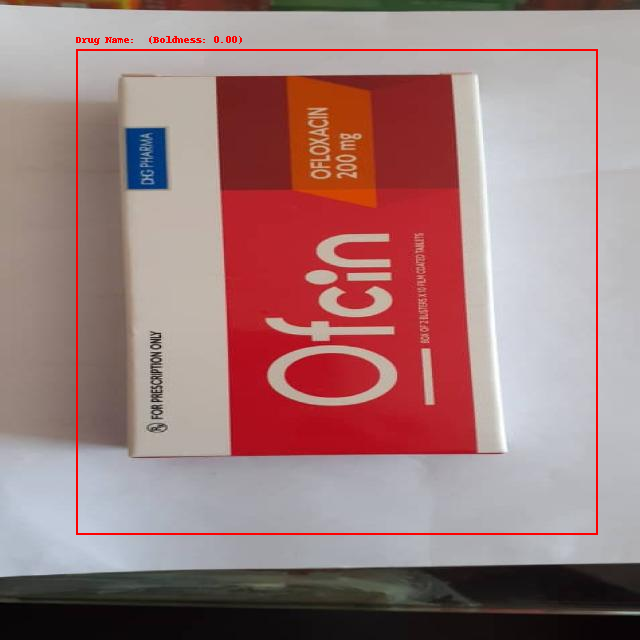

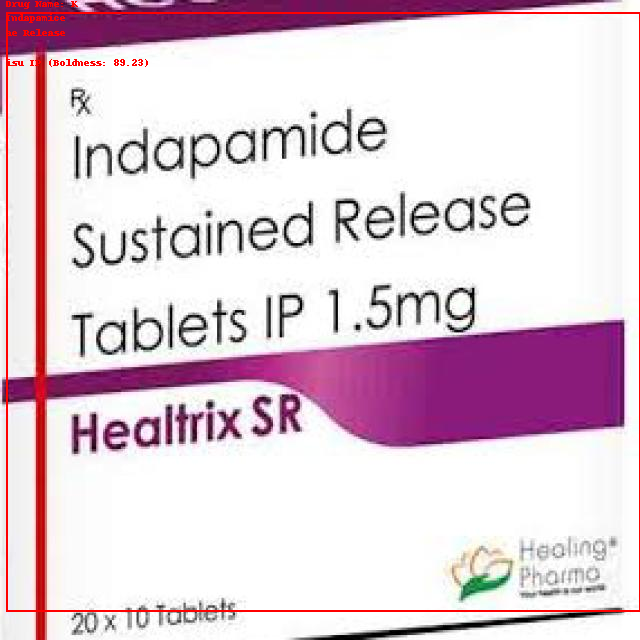

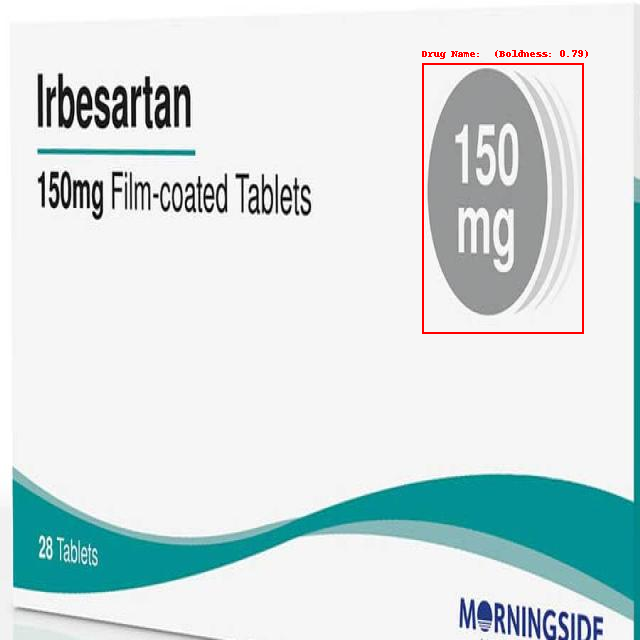

In [62]:
import pytesseract
from operator import itemgetter

# Function to calculate boldness of text
def calculate_boldness(image):
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Convert the grayscale image to 8-bit unsigned integer type
    gray = np.uint8(gray)
    # Apply adaptive thresholding
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    # Calculate boldness by counting non-zero pixels
    boldness = np.sum(binary) / (np.prod(binary.shape))
    return boldness

# Counter for limiting the display to 10 images
display_count = 0

# Visualize and display the top 10 accurate results for each image
for i, (image, prediction) in enumerate(zip(test_dataset, predictions)):
    # Counter check for limiting the display to 10 images
    if display_count >= 10:
        break

    # Create a new PIL Image with the visualization
    visualization = F.to_pil_image(image.cpu())
    draw = ImageDraw.Draw(visualization)

    # Assuming prediction['boxes'], ['labels'], and ['scores'] contain the bounding boxes, labels, and scores
    detections = [{'box': box, 'label': label, 'score': score} for box, label, score in
                  zip(prediction['boxes'], prediction['labels'], prediction['scores'])]

    # Sort detections by confidence score in descending order
    detections.sort(key=itemgetter('score'), reverse=True)

    # Initialize variables to store the region with maximum boldness
    max_boldness_region = None
    max_boldness_score = 0

    # Iterate through detections to find the region with maximum boldness
    for detection in detections:
        box = detection['box']

        # Extract the region of interest from the image using the bounding box
        roi = image[:, int(box[1]):int(box[3]), int(box[0]):int(box[2])]

        # Convert the region of interest to a NumPy array
        roi_np = np.array(roi.permute(1, 2, 0))

        # Calculate the boldness of the text in the region
        boldness = calculate_boldness(roi_np)

        # Update if the boldness is higher than the current maximum
        if boldness > max_boldness_score:
            max_boldness_score = boldness
            max_boldness_region = box

    # If a region with maximum boldness is found, visualize the bounding box
    if max_boldness_region is not None:
        draw.rectangle(max_boldness_region.tolist(), outline='red', width=2)

        # Extract the region of interest from the image using the bounding box
        roi = image[:, int(max_boldness_region[1]):int(max_boldness_region[3]),
              int(max_boldness_region[0]):int(max_boldness_region[2])]

        # Convert the region of interest to a PIL Image
        roi_pil = F.to_pil_image(roi.cpu())

        # Use pytesseract to extract text from the region of interest
        text = pytesseract.image_to_string(roi_pil)

        # Display the drug name with explicit encoding
        draw.text((max_boldness_region[0], max_boldness_region[1] - 15),
                  f'Drug Name: {text.strip()} (Boldness: {max_boldness_score:.2f})'.encode('utf-8').decode('latin-1'),
                  fill='red')

        # Display the image
        display(visualization)

        # Increment the display count
        display_count += 1
